# Background:
* Zalando SE is a European e-commerce company based in Berlin, Germany. The company follows a platform approach, offering Fashion and Lifestyle products to customers in 17 European markets. 

* Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 labled examples 
***

# The Imports:

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)
from tqdm import tnrange, tqdm_notebook, tqdm
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import cv2        
from PIL import Image

### Warning:
Set <u>download = True </u>if dataset is not downloaded.

In [9]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=False #set this as true to download the data
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

***
# The Data:

Label: 9


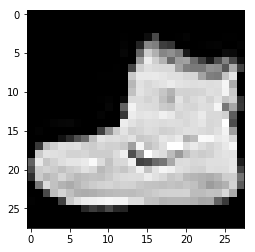

In [10]:
sample = next(iter(train_set))
image,label = sample #sequence unpacking
plt.imshow(image.squeeze(), cmap="gray")
print("Label:", label)

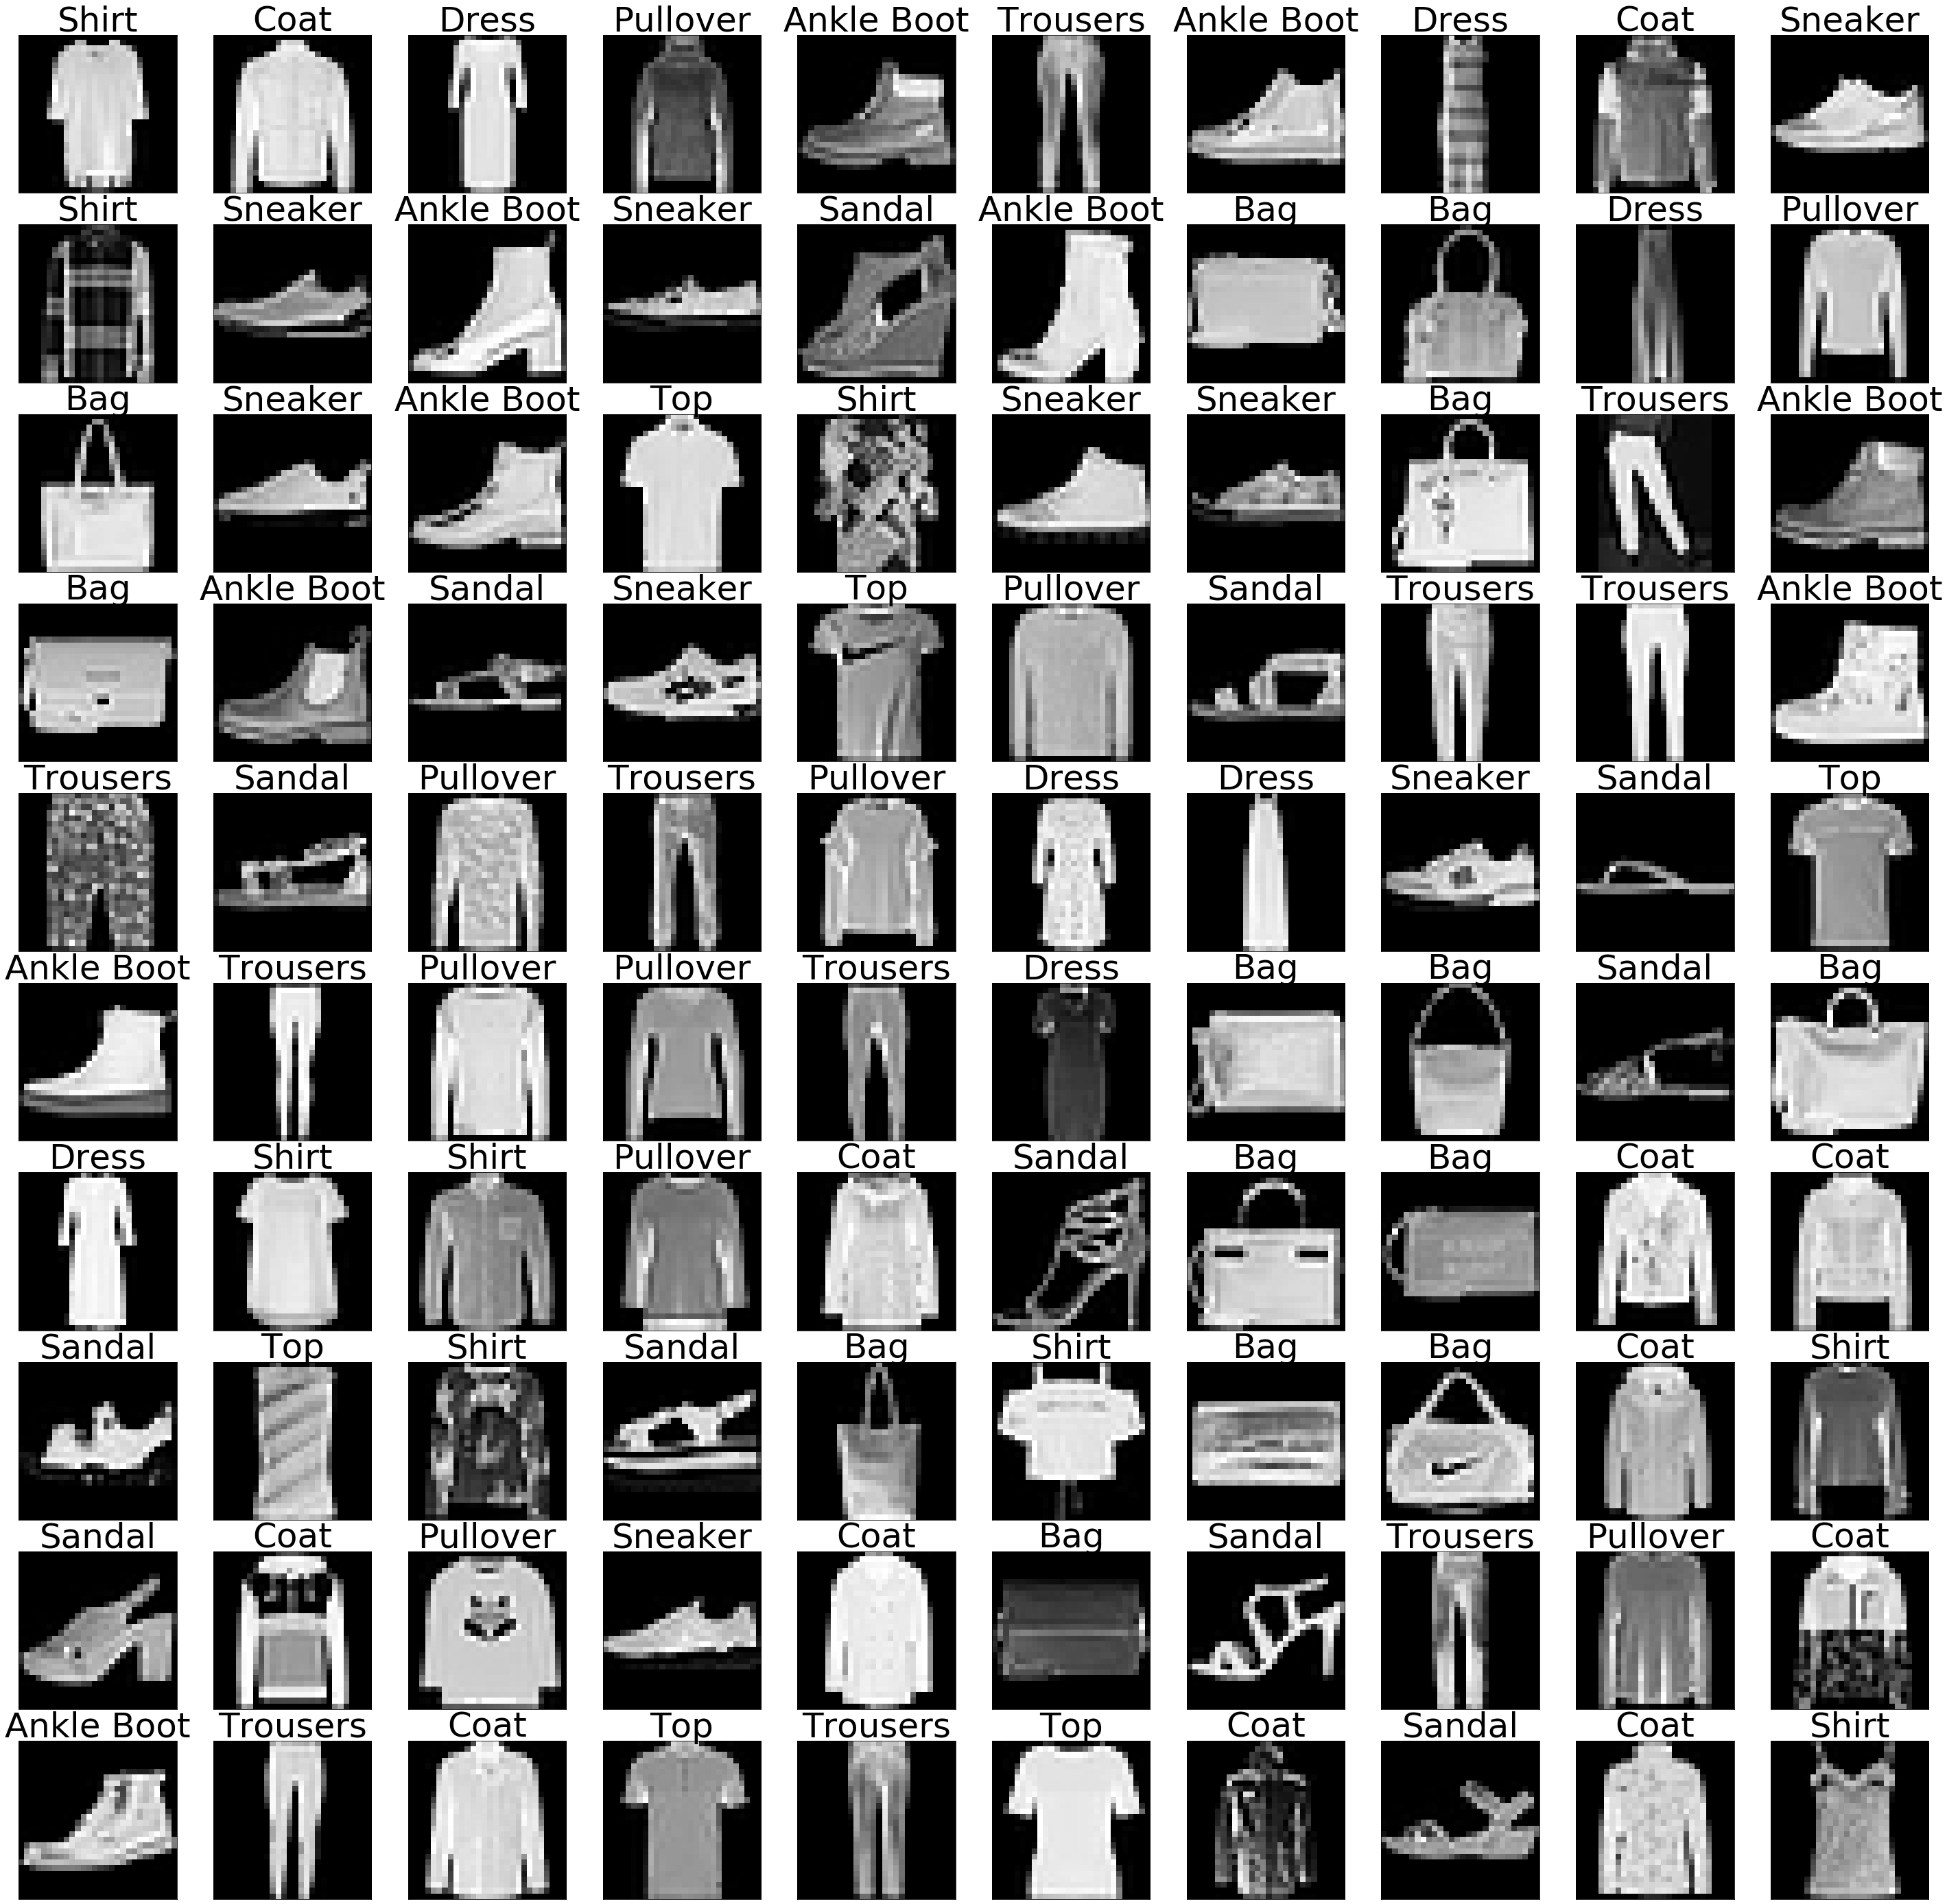

In [11]:
how_many_to_plot = 100

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=True
)

mapping = {
    0:'Top', 1:'Trousers', 2:'Pullover', 3:'Dress', 4:'Coat'
    ,5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'
}

plt.figure(figsize=(50,50))
for i, batch in enumerate(train_loader, start=1):
    image, label = batch
    plt.subplot(10,10,i)
    fig = plt.imshow(image.reshape(28,28), cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(mapping[label.item()], fontsize=50)
    if (i >= how_many_to_plot): break
plt.show()

# prints 100 instances from the training data

****
# The Model:

In [13]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t=t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        # 4,4 are height of each of the 12 output channels
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        

        return t

In [14]:
network=Network() # Warning: running this cell resets the weights

In [15]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
optimizer = optim.Adam(network.parameters(), lr=0.01)
train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=100
    ,shuffle=True
)


In [16]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


***
# Training the model:

In [17]:
loss_list=[]
acc_list=[]
for epoch in tnrange(10):
    

    total_loss = 0
    total_correct = 0

    for batch in tqdm_notebook(train_loader): # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
        
        
    )
    
    loss_list.append(total_loss)
    acc_list.append((total_correct)/60000)

epoch 0 total_correct: 46891 loss: 343.70078229904175


epoch 1 total_correct: 51506 loss: 229.26116923987865


epoch 2 total_correct: 52026 loss: 213.327601313591


epoch 3 total_correct: 52239 loss: 206.2582135796547


epoch 4 total_correct: 52532 loss: 201.75455889105797


epoch 5 total_correct: 52576 loss: 196.9407666772604


epoch 6 total_correct: 52655 loss: 196.41009011864662


epoch 7 total_correct: 53061 loss: 186.49155435711145


epoch 8 total_correct: 53031 loss: 189.10001762211323


epoch 9 total_correct: 53160 loss: 182.22539925575256



# The stats:

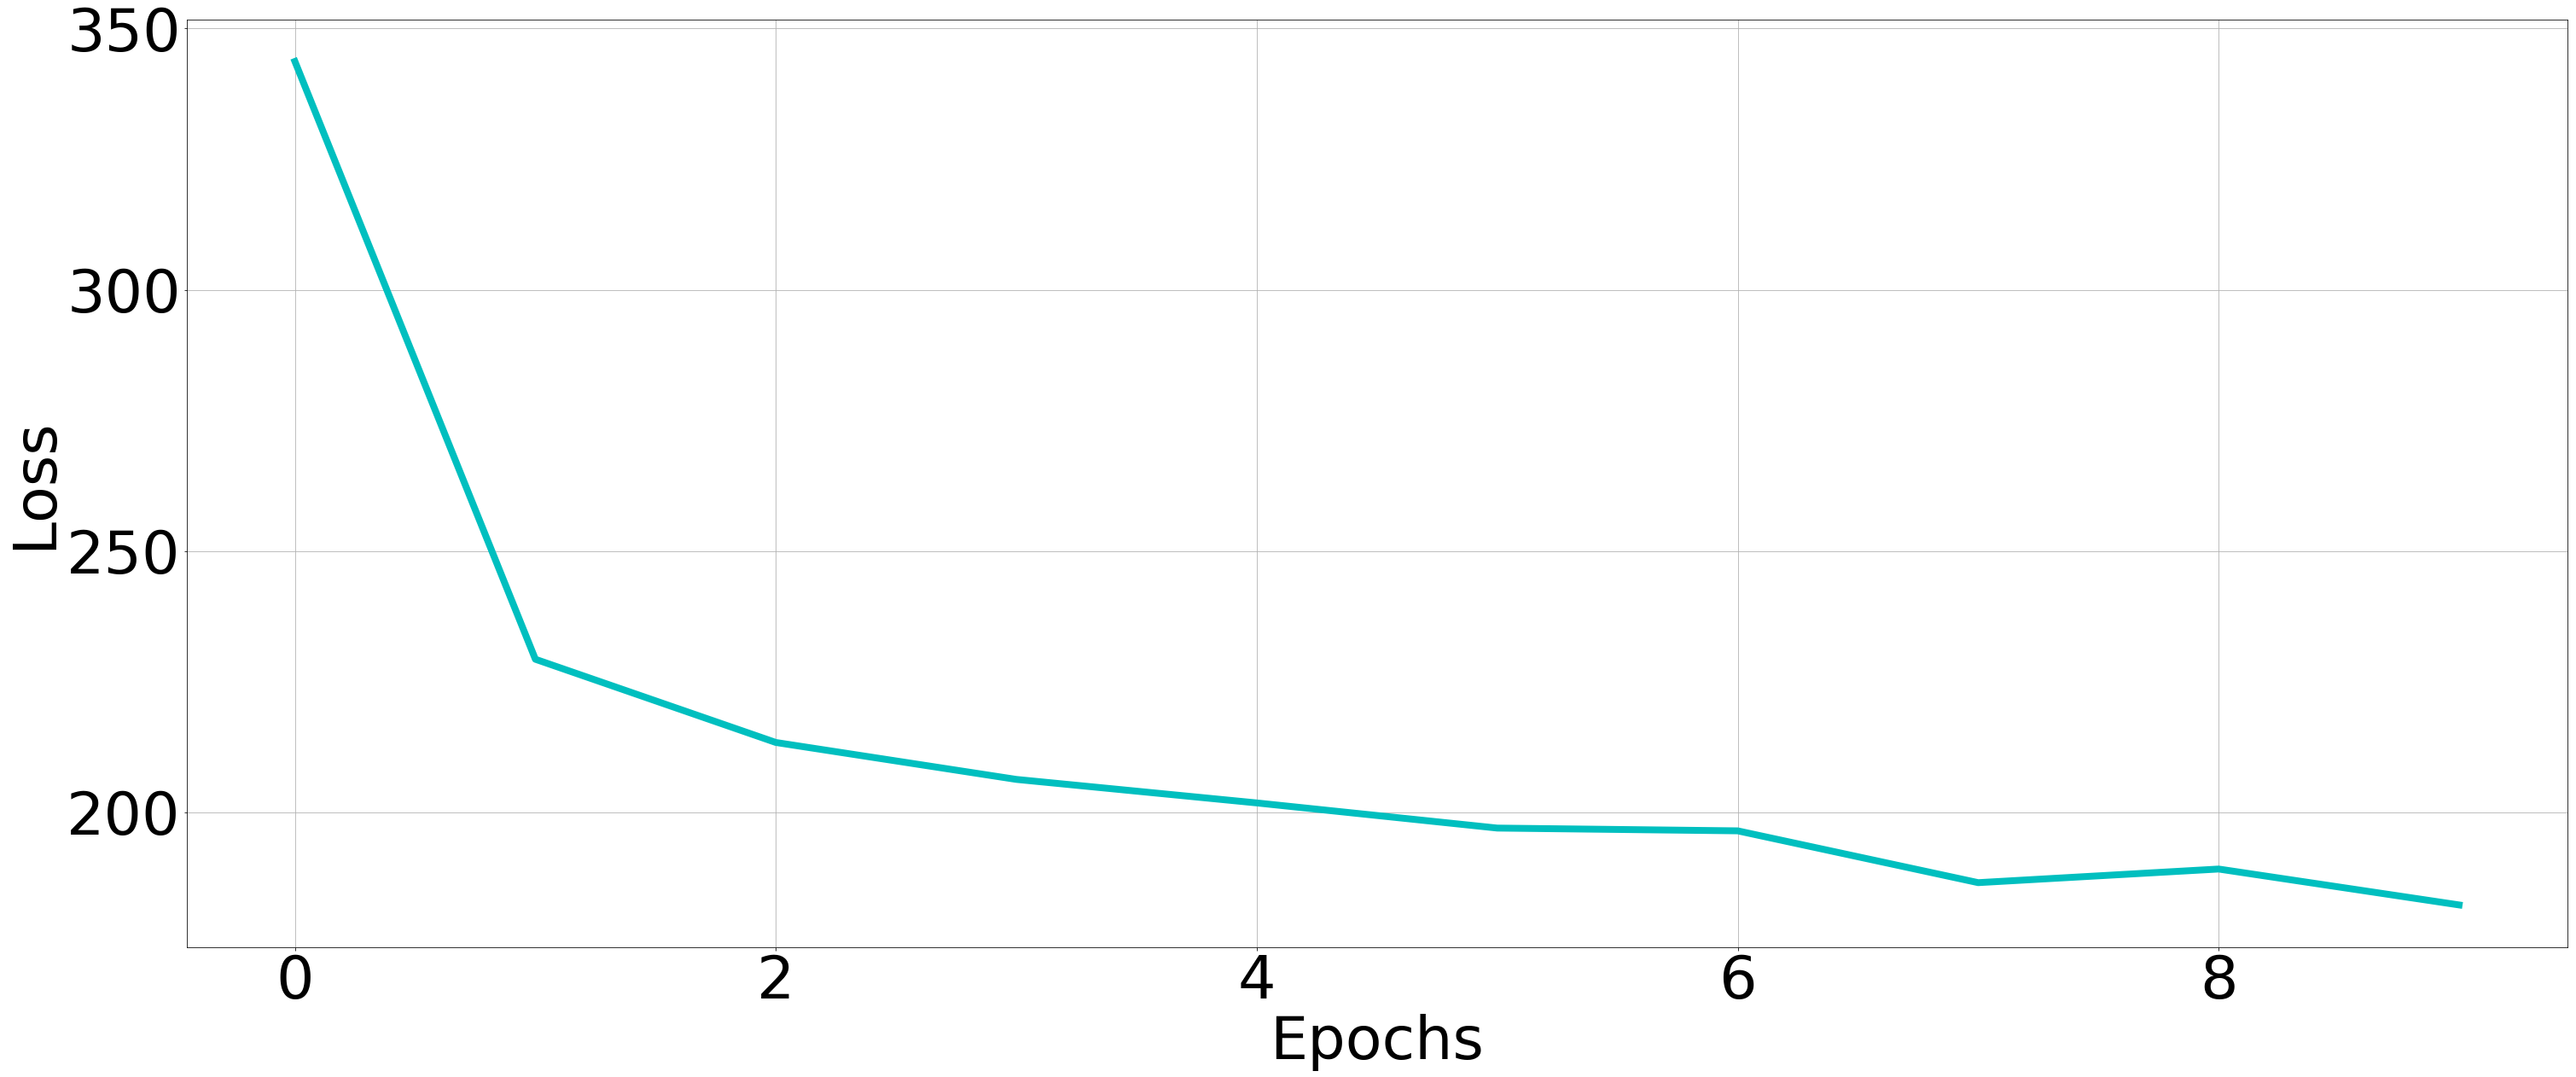

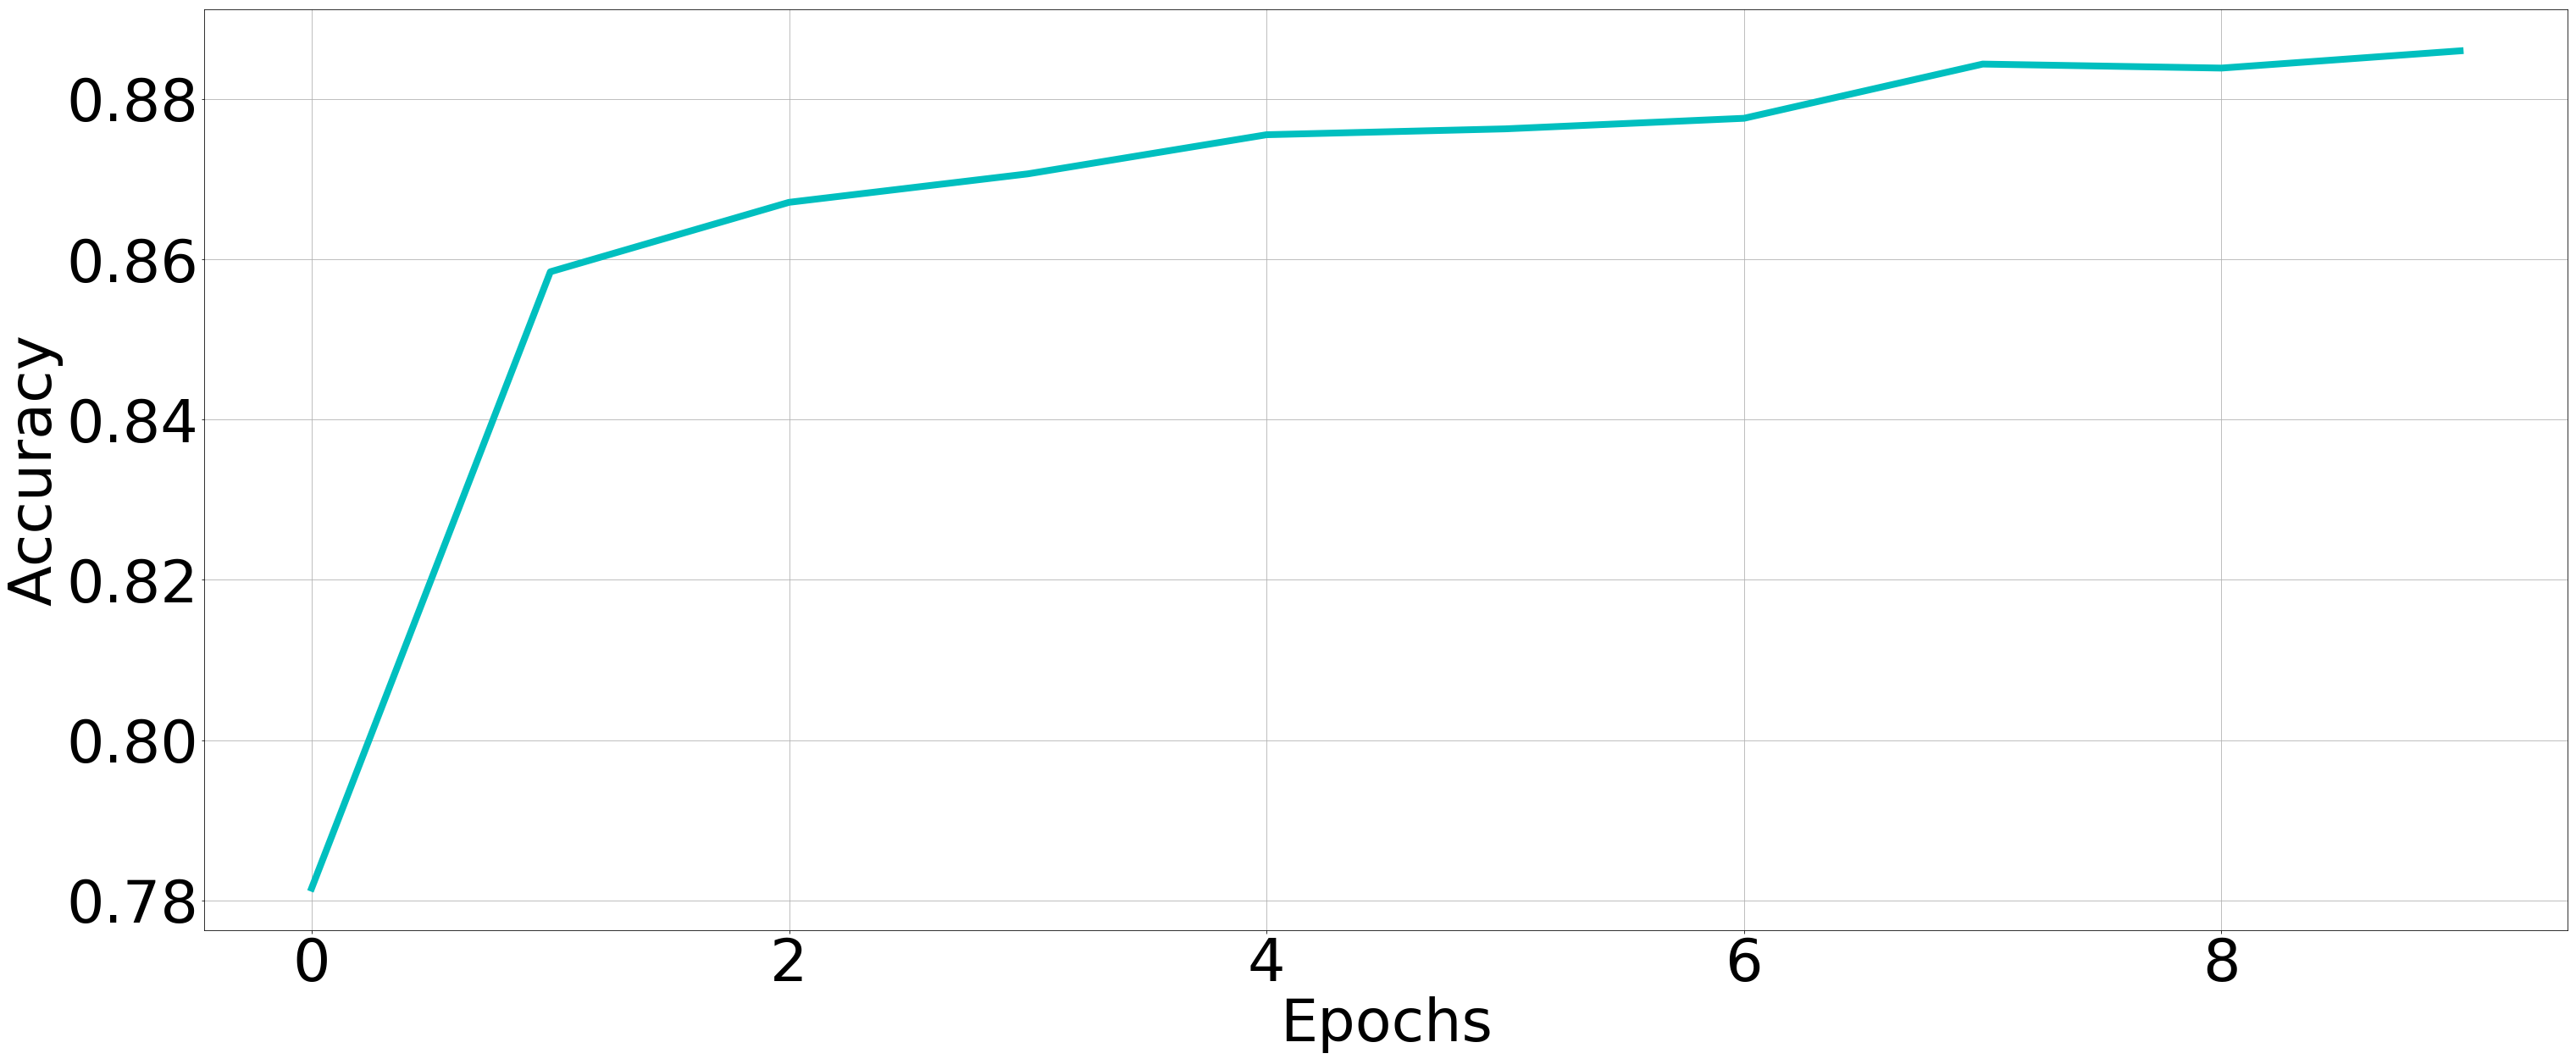

In [18]:
plt.figure(figsize=(50,20))
plt.rcParams.update({'font.size': 70})
plt.xlabel("Epochs") 
plt.ylabel("Loss")  
plt.title("")
plt.plot( [0,1,2,3,4,5,6,7,8,9],loss_list , linewidth=8, linestyle="-", c="c")
plt.grid(True)
plt.show()

plt.figure(figsize=(50,20))
plt.rcParams.update({'font.size': 70})
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")  
plt.title("")
plt.plot( [0,1,2,3,4,5,6,7,8,9],acc_list , linewidth=8, linestyle="-", c="c")
plt.grid(True)
plt.show()

## Inferences:
* Loss decreases through the epochs
* Accuracy Increases through the epochs

Good news!
***

### Misc:

In [19]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in (loader):
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [20]:
with torch.no_grad(): # grad tracking turned off
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=5000)
    train_preds = get_all_preds(network, prediction_loader)

In [23]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print("Total_correct:", preds_correct, "out of 60,000")
print("Accuracy: ", (preds_correct/len(train_set))*100, "%")

Total_correct: 53560 out of 60,000
Accuracy:  89.26666666666667 %


# The Confusion Matrix:

In [24]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))

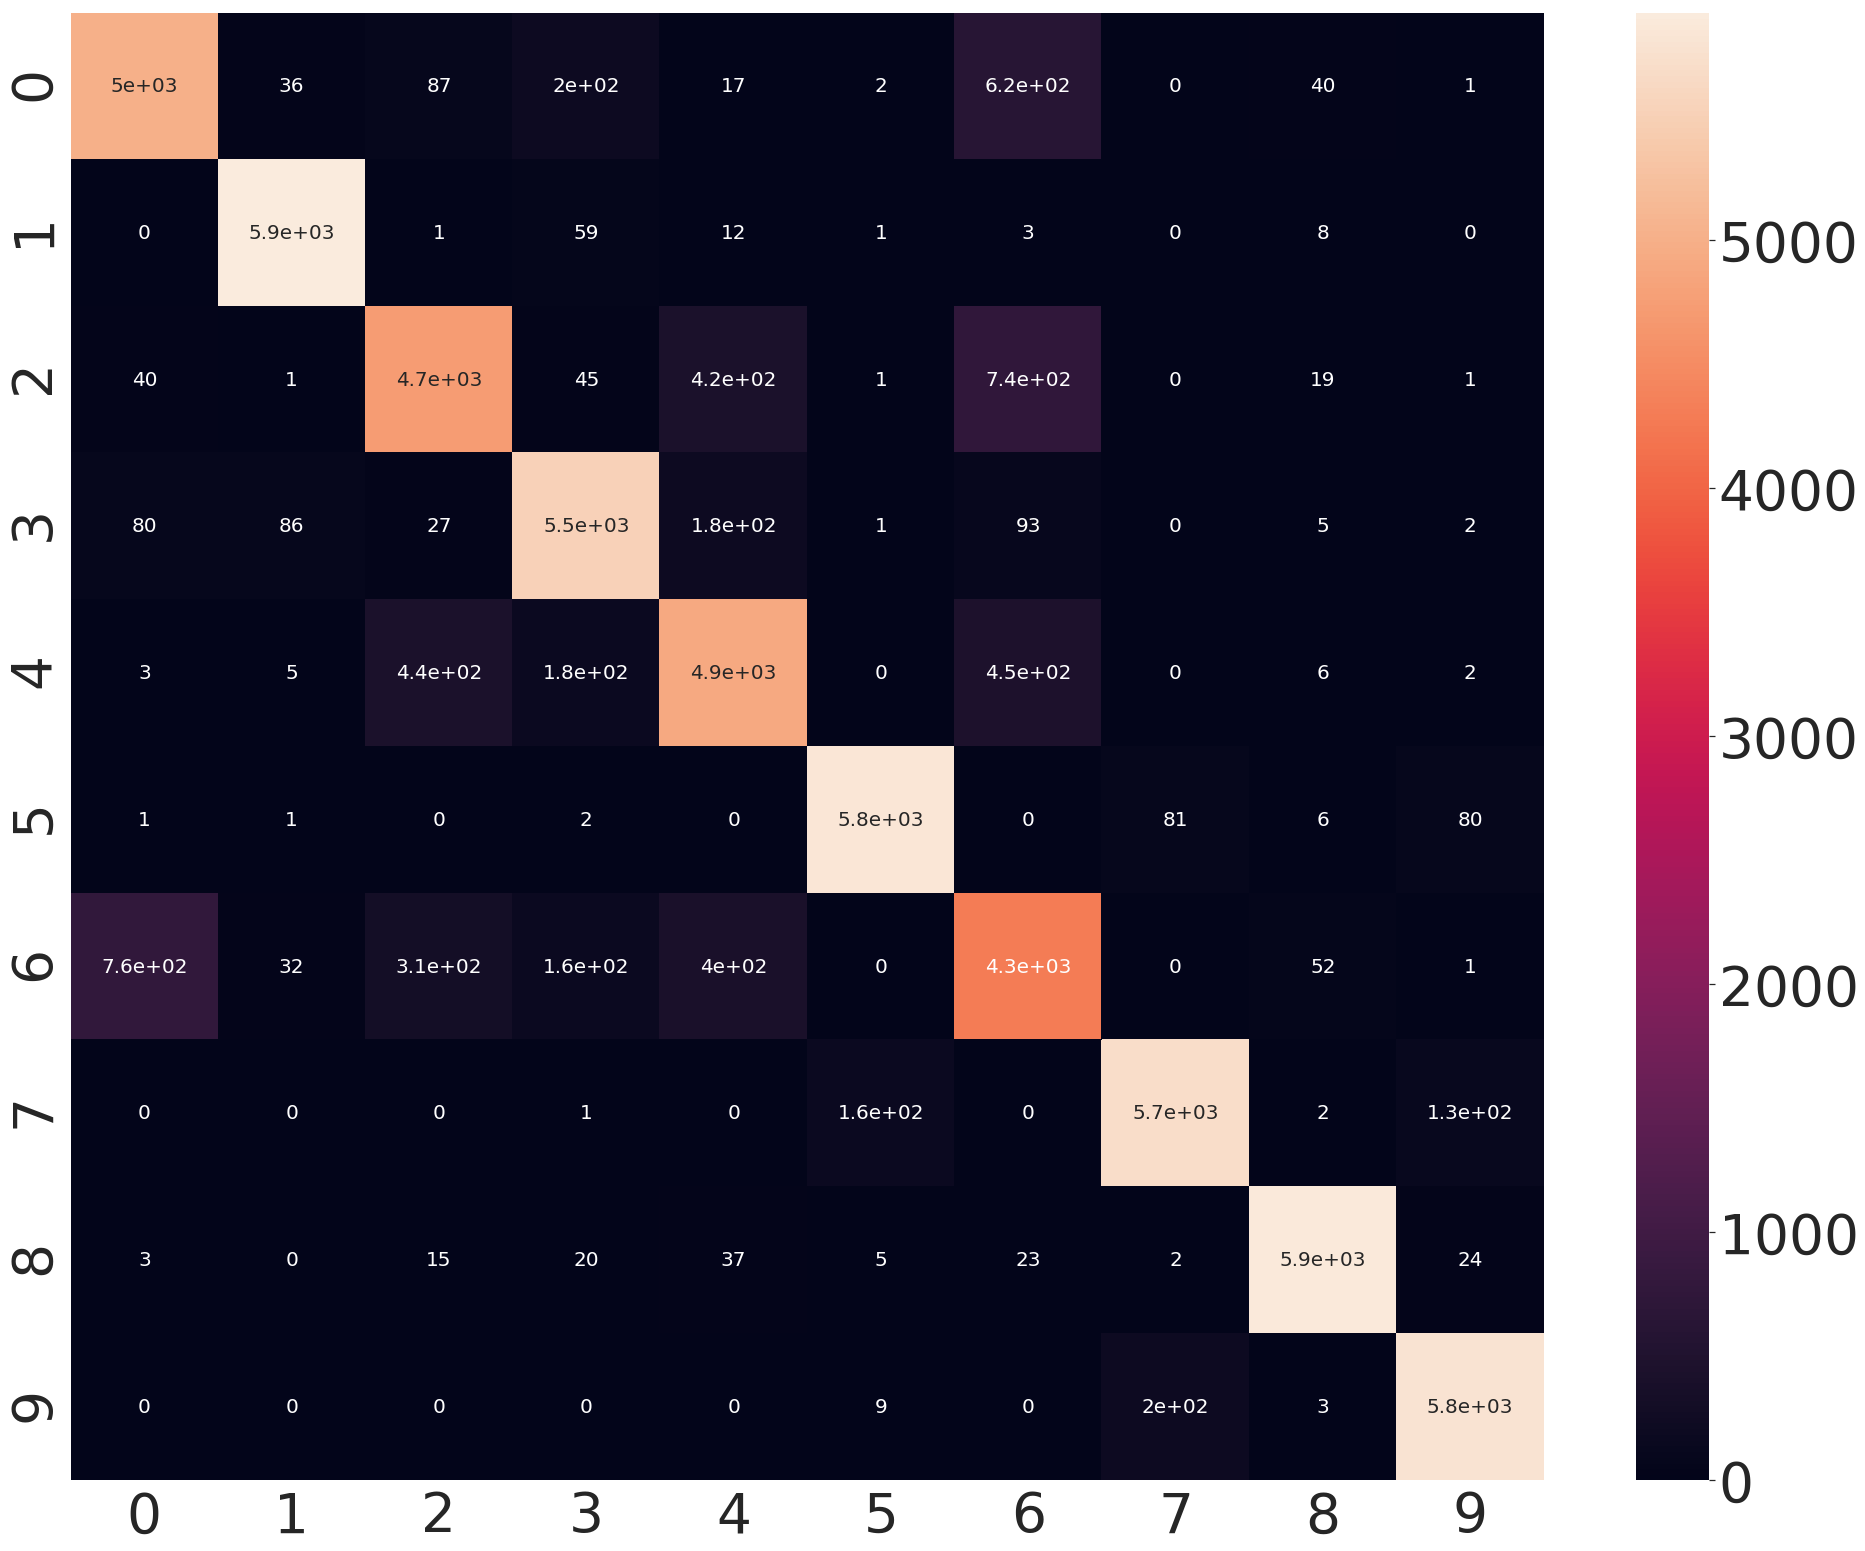

In [25]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = list(cm)

df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(33,27))
sn.set(font_scale=5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}) # font size

plt.show()

***
# Then: 
* Step_1: Google Trousers
* Step_2: Download image
* Step_3: Augment if required

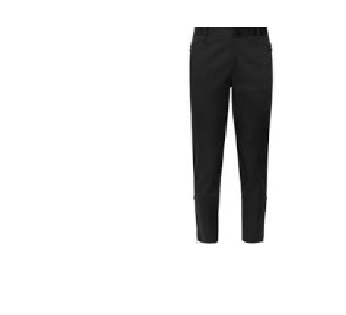

In [26]:
# source: https://www.thetrendspotter.net/types-of-pants-for-men/
IMG_SIZE = 150
path = 'Trousers.jpg'
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
plt.axis('off')
plt.imshow(img, cmap="gray")

### Basic Augmentation:
* Image resize
* Negative

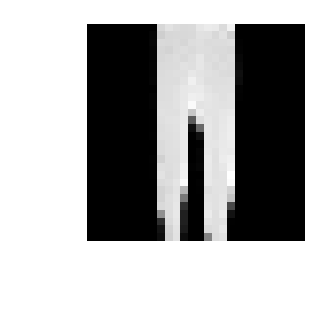

In [27]:
IMG_SIZE=28
path = 'Trousers.jpg'
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
img_boi = cv2.bitwise_not(img)
plt.axis('off')
plt.imshow(img_boi, cmap="gray")

In [28]:
img_t = torch.from_numpy(img_boi)
img_t2=img_t.reshape([1,1,28,28])
img_t3= img_t2.float()
pred_trousers= network(img_t3)

In [29]:
pred_trousers.argmax(dim=1)

tensor([1])

### Tensor([1]) coresponds to a pair of trousers
0. Top
1. <u>Trousers</u>
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle Boot


the model worked yet again!
***
### Another example.

A black leather bag from Zara.

Just in case you liked it, source: https://www.zara.com/in/en/minimal-tote-bag-p16072084.html?v1=37835796&v2=1445798

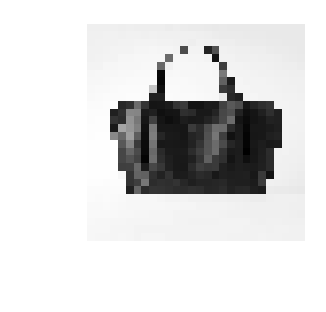

In [30]:
# source: https://www.zara.com/in/en/minimal-tote-bag-p16072084.html?v1=37835796&v2=1445798

path = 'Nice_looking_bag.jpg'
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
plt.axis('off')
plt.imshow(img, cmap="gray")

### Basic Augmentation:
* Image resize
* Negative

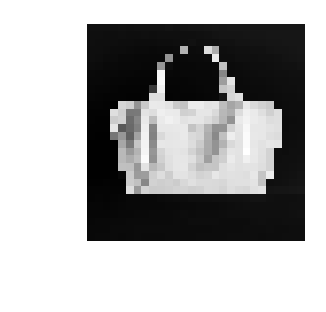

In [31]:
IMG_SIZE=28
path = 'Nice_looking_bag.jpg'
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
img_boi = cv2.bitwise_not(img)
plt.axis('off')
plt.imshow(img_boi, cmap="gray")

In [35]:
img_t = torch.from_numpy(img_boi)
img_t2=img_t.reshape([1,1,28,28])
img_t3= img_t2.float()
pred_bag= network(img_t3)

In [36]:
pred_bag.argmax(dim=1)

tensor([8])

### Tensor([8])  corresponds to a bag.

0. Top
1. Trousers
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. <u>Bag</u>
9. Ankle Boot


### The model worked yet again!

***

### To Do:
* Try out the test set